# Clasificador de reseñas

## Imports necesariosimport pandas as pd

In [22]:
import pandas as pd
import os
import torch
import numpy as np
from transformers import BertForSequenceClassification, BertTokenizerFast, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support

## Importar los datos

### Funciones que se van a utilizar

Función para exportar un txt a un dataframe 

In [2]:
def importFromTxtToDF(source, label):
    with open(source, 'r', encoding="utf-8") as file:
        #Generate a list with all the reviews
        targetList = [line.strip() for line in file]

    targetDF = pd.DataFrame(targetList, columns=['review'])

    targetDF["label"] = label
    
    return targetDF

In [3]:
def dataToDataFrames(invalidReviewsPath, validReviewsPath):
    
    #Export data to dataframes
    invalidReviewsDF = importFromTxtToDF(invalidReviewsPath, "n") # n is the label of the invalid reviews
    validReviewsDF = importFromTxtToDF(validReviewsPath, "v") # v is the label of the valid reviews
    
    #Combine dataframes
    dataDF = pd.concat([invalidReviewsDF, validReviewsDF], ignore_index = True)
    
    #Shuffle the dataframe
    return dataDF.sample(frac = 1).reset_index(drop = True)

### Datos originales

Con datos originales nos referimos a aquellos que no han sido generados usando técnicas de aumento de datos.

In [4]:
originalInvalidReviewsPath = "../1. Data/4. Labeled Reviews/2. Without Emojis/InvalidReviews.txt"
originalValidReviewsPath = "../1. Data/4. Labeled Reviews/2. Without Emojis/ValidReviews.txt"

originalDF = dataToDataFrames(originalInvalidReviewsPath, originalValidReviewsPath)

Se muestran los datos

In [5]:
originalDF.head()

review label
0  "No está mal, a veces en urgencias un poco cao...     n
1  "Atención excelente, personal muy preparado ve...     n
2  "Una parada de.metro más no tiene nada bueno n...     v
3  "Por lo menos en lo que respecta al metro está...     v
4  "Este hospital es una vergüenza. Pésima atenci...     n

Número de elementos de cada clase

In [6]:
originalDF["label"].value_counts()

label
v    1943
n    1291
Name: count, dtype: int64

Para que las clases sean compatibles con el entrenamiento, se va a hacer que la columna label sea numérica: n = 0 y v = 1

In [7]:
originalDF['label'] = originalDF['label'].map({'v': 1, 'n': 0})

In [8]:
originalDF.head()

review  label
0  "No está mal, a veces en urgencias un poco cao...      0
1  "Atención excelente, personal muy preparado ve...      0
2  "Una parada de.metro más no tiene nada bueno n...      1
3  "Por lo menos en lo que respecta al metro está...      1
4  "Este hospital es una vergüenza. Pésima atenci...      0

### Datos sintéticos

Estos datos son aquellos que se han generado mediante las técnicas de aumento de datos

#### Retrotraducción

In [9]:
backtranslationInvalidReviewsPath = "1. Data Augmentation/1. Back Translation/3. Augmented Data/InvalidBackTranslationData.txt"
backtranslationValidReviewsPath = "1. Data Augmentation/1. Back Translation/3. Augmented Data/ValidBackTranslationData.txt"

bactranslationDF = dataToDataFrames(backtranslationInvalidReviewsPath, backtranslationValidReviewsPath)

Se muestran los datos

In [10]:
bactranslationDF.head()

review label
0  “El tren pasa cada ocho minutos durante todo e...     v
1                          "Buena estación de metro"     v
2                          "Es una bonita estación".     v
3  "Clínica KIHARU. Fui por primera vez al centro...     n
4                   "El enchufe está bien conectado"     v

Número de elementos en cada clase

In [11]:
bactranslationDF["label"].value_counts()

label
v    1943
n    1272
Name: count, dtype: int64

#### Modelos de lenguaje preentreandos

In [12]:
pretrainedNLPInvalidReviewsPath = "1. Data Augmentation/2. Pretrained NLP/2. Augmented Data/InvalidGPT4oMiniData.txt"
pretrainedNLPValidReviewsPath = "1. Data Augmentation/2. Pretrained NLP/2. Augmented Data/ValidGPT4oMiniData.txt"

pretrainedNLPDF = dataToDataFrames(pretrainedNLPInvalidReviewsPath, pretrainedNLPValidReviewsPath)

Se muestran los datos

In [13]:
pretrainedNLPDF.head()

review label
0                           ""Claro y sin enredos.""     v
1  "Las estaciones y paradas de autobús están ext...     v
2  "El intercambiador de metro en Madrid, donde c...     v
3  "Te diriges a la Calle Goya, repleta de cafete...     n
4                           ""Qué hermoso ocaso...""     n

Número de elementos en cada clase

In [14]:
pretrainedNLPDF["label"].value_counts()

label
v    1943
n    1291
Name: count, dtype: int64

#### Mixed EDA

Este conjunto de datos se ha construido usando las técnicas de: reemplazo por sinónimos, inserción aleatoria, eliminación aleatoria e intercambio aleatorio.

In [15]:
mixedEDAInvalidReviewsPath = "1. Data Augmentation/7. Mixed EDA/2. Augmented Data/InvalidMixedEDAData.txt"
mixedEDAValidReviewsPath = "1. Data Augmentation/7. Mixed EDA/2. Augmented Data/ValidMixedEDAData.txt"

mixedEDADF = dataToDataFrames(mixedEDAInvalidReviewsPath, mixedEDAValidReviewsPath)

Se muestran los datos

In [16]:
mixedEDADF.head()

review label
0  "un tanto de considerablemente sustancialmente...     n
1  "Viajar en tren horario en Madrid me parece la...     v
2                                           "quieto"     v
3  "La entrada partida / estan de la bebés de gas...     v
4  ""Me encanta este y más con el paso de los año...     v

Número de elementos en cada clase

In [17]:
mixedEDADF["label"].value_counts()

label
v    1943
n    1291
Name: count, dtype: int64

#### Albumentación

In [18]:
albumentationInvalidReviewsPath = "1. Data Augmentation/8. Albumentation/2. Augmented Data/InvalidAlbumentationData.txt"
albumentationValidReviewsPath = "1. Data Augmentation/8. Albumentation/2. Augmented Data/ValidAlbumentationData.txt"

albumentationDF = dataToDataFrames(albumentationInvalidReviewsPath, albumentationValidReviewsPath)

Se muestran los datos

In [19]:
albumentationDF.head()

review label
0  "Un lugar emblemático de Madrid con un gran ed...     v
1  "Limpio. Fallan los avisos del display. Nunca ...     v
2  "El servicio depende del momento. Todo amplio....     v
3  "He viajado desde Madrid a Argentina sola y el...     n
4  "Trabaje en ella y mi experiencia profesional ...     n

Número de elementos en cada clase

In [20]:
albumentationDF["label"].value_counts()

label
v    1943
n    1291
Name: count, dtype: int64

#### Combinación de todos los métodos (unión de los dataframes)

In [21]:
#Combine dataframes
syntheticDF = pd.concat([bactranslationDF, pretrainedNLPDF, mixedEDADF, albumentationDF], ignore_index = True)

#Shuffle the dataframe
syntheticDF = syntheticDF.sample(frac = 1).reset_index(drop = True)

Se muestran los datos

In [22]:
syntheticDF.head()

review label
0    "Es una estación antigua con muchas escaleras."     v
1  "Caminar está bien, pero hay que tener cuidado...     v
2  ""Entrada obsoleta, carente de elevador y esca...     v
3  "Tardan borde la vida en darte y el guardia de...     n
4                                 "bello bonito "Un"     v

Número de elementos de cada clase

In [23]:
syntheticDF["label"].value_counts()

label
v    7772
n    5145
Name: count, dtype: int64

Para que las clases sean compatibles con el entrenamiento, se va a hacer que la columna label sea numérica: n = 0 y v = 1

In [24]:
syntheticDF['label'] = syntheticDF['label'].map({'v': 1, 'n': 0})

In [25]:
syntheticDF.head()

review  label
0    "Es una estación antigua con muchas escaleras."      1
1  "Caminar está bien, pero hay que tener cuidado...      1
2  ""Entrada obsoleta, carente de elevador y esca...      1
3  "Tardan borde la vida en darte y el guardia de...      0
4                                 "bello bonito "Un"      1

Como se puede ver, se ha multiplicado por 5 el número de datos disponibles para entrenar el clasificador

## Diseño y entrenamiento del clasificador de reseñas

Se va a realizar el entrenamiento en dos etapas: la primera etapa de preentrenamiento para adaptar al modelo al dominio y estilo de las reseñas, utilizando únicamente los datos sintéticos. Y una seguanda etapa, la de refinamiento, con los datos reales para qeu el modelo se adapte a la verdadera distribución y complejiad de las reseñas.



### Etapa 1

#### Elección del modelo

In [26]:
modelName = 'bert-base-uncased'
tokenizer = BertTokenizerFast.from_pretrained(modelName)
model = BertForSequenceClassification.from_pretrained(modelName, num_labels = 2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Preparación de los datos

Convertir los datos a un dataset de HuggingFace

In [27]:
syntheticDataset = Dataset.from_pandas(syntheticDF)

print(syntheticDataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 12917
})


Función para tokenizar los textos

In [28]:
def tokenizeFunction(examples):
    return tokenizer(examples["review"], truncation=True, padding='max_length', max_length=512)

Tokenizar y preparar el dataset sintético

In [29]:
syntheticDataset = syntheticDataset.map(tokenizeFunction, batched = True)
syntheticDataset = syntheticDataset.shuffle(seed = 42)
syntheticDataset.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 12917/12917 [00:01<00:00, 7996.16 examples/s]


#### Configuración del entrenamiento

In [30]:
savingPath = "/home/ibon/Documentos/1. Models/Clasificador/TrainingSynthetic"


syntheticTrainingArgs = TrainingArguments(
    output_dir = savingPath,
    num_train_epochs = 3,                
    per_device_train_batch_size = 8,     
    per_device_eval_batch_size = 8,
    evaluation_strategy = "no", # no evaluation
    save_strategy = "epoch",
    logging_steps = 10,
    fp16 = True, # Activate mixed precision for the RTX 3060 
)

syntheticTrainer = Trainer(
    model = model,
    args = syntheticTrainingArgs,
    train_dataset = syntheticDataset,
)


/home/ibon/Programas/anaconda3/envs/TFG/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Entrenamiento con datos sintéticos

In [31]:
syntheticTrainer.train()

TrainOutput(global_step=4845, training_loss=0.37633486593716897, metrics={'train_runtime': 1031.9016, 'train_samples_per_second': 37.553, 'train_steps_per_second': 4.695, 'total_flos': 1.019581650625536e+16, 'train_loss': 0.37633486593716897, 'epoch': 3.0})

Guardar el modelo

In [33]:
savingPath = "/home/ibon/Documentos/1. Models/Clasificador/ResultsSynthetic"

model.save_pretrained(savingPath)
tokenizer.save_pretrained(savingPath)

('/home/ibon/Documentos/1. Models/Clasificador/ResultsSynthetic/tokenizer_config.json',
 '/home/ibon/Documentos/1. Models/Clasificador/ResultsSynthetic/special_tokens_map.json',
 '/home/ibon/Documentos/1. Models/Clasificador/ResultsSynthetic/vocab.txt',
 '/home/ibon/Documentos/1. Models/Clasificador/ResultsSynthetic/added_tokens.json',
 '/home/ibon/Documentos/1. Models/Clasificador/ResultsSynthetic/tokenizer.json')

### Etapa 2

#### Carga del modelo y el tokenizador de la etapa anterior

In [9]:
savingPath = "/home/ibon/Documentos/1. Models/Clasificador/ResultsSynthetic"
tokenizer = BertTokenizerFast.from_pretrained(savingPath)
model = BertForSequenceClassification.from_pretrained(savingPath, num_labels = 2)

#### Preparación de los datos

In [10]:
def trainTestValidationSplit(dataset, trainPctg = 0.8):
    datasetSplit = dataset.train_test_split(test_size = 1 - trainPctg, seed = 54)
    validationTestSplit = datasetSplit["test"].train_test_split(test_size = 0.5, seed = 54)
    
    return DatasetDict({
        "train" : datasetSplit["train"],
        "test" : validationTestSplit["test"],
        "validation" : validationTestSplit["train"]
        })

Convertir el conjunto de datos en un dataset de HuggingFace

In [11]:
originalDataset = Dataset.from_pandas(originalDF)

print(originalDataset)

Dataset({
    features: ['review', 'label'],
    num_rows: 3234
})


Dividir el conjunto de datos en entrenamiento, validación y test

In [12]:
originalDataDict = trainTestValidationSplit(originalDataset)

print(originalDataDict)

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 2587
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 324
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 323
    })
})


Función para tokenizar los textos

In [13]:
def tokenizeFunction(examples):
    return tokenizer(examples["review"], truncation=True, padding='max_length', max_length=512)

Tokenizar y preparar el dataset con datos originales

In [14]:
originalDataDict = originalDataDict.map(tokenizeFunction, batched = True)
originalDataDict.set_format(type = 'torch', columns = ['input_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 323/323 [00:00<00:00, 7442.67 examples/s]


#### Configuración del entrenamiento

Función de métricas

In [15]:
def computeMetrics(p):
    preds = p.predictions.argmax(axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [16]:
savingPath = "/home/ibon/Documentos/1. Models/Clasificador/TrainingOriginalData"

originalDatatrainingArgs = TrainingArguments(
    output_dir = savingPath,
    num_train_epochs = 3,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    metric_for_best_model = "accuracy",
)

originalDataTrainer = Trainer(
    model = model,
    args = originalDatatrainingArgs,
    train_dataset = originalDataDict['train'],
    eval_dataset = originalDataDict['validation'],
    compute_metrics = computeMetrics
)

/home/ibon/Programas/anaconda3/envs/TFG/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


#### Ajuste del modelo con datos originales

In [17]:
originalDataTrainer.train()

TrainOutput(global_step=972, training_loss=0.27268277078008457, metrics={'train_runtime': 457.1571, 'train_samples_per_second': 16.977, 'train_steps_per_second': 2.126, 'total_flos': 2042004900648960.0, 'train_loss': 0.27268277078008457, 'epoch': 3.0})

#### Guardar el clasificador

In [18]:
savingPath = "/home/ibon/Documentos/1. Models/Clasificador/ResultsOriginalData"

model.save_pretrained(savingPath)
tokenizer.save_pretrained(savingPath)

('/home/ibon/Documentos/1. Models/Clasificador/ResultsOriginalData/tokenizer_config.json',
 '/home/ibon/Documentos/1. Models/Clasificador/ResultsOriginalData/special_tokens_map.json',
 '/home/ibon/Documentos/1. Models/Clasificador/ResultsOriginalData/vocab.txt',
 '/home/ibon/Documentos/1. Models/Clasificador/ResultsOriginalData/added_tokens.json',
 '/home/ibon/Documentos/1. Models/Clasificador/ResultsOriginalData/tokenizer.json')

#### Evaluación del modelo sobre el conjunto de test

Classification Report:

              precision    recall  f1-score   support

    inválida       0.84      0.95      0.89       111
      válida       0.97      0.91      0.94       213

    accuracy                           0.92       324
   macro avg       0.90      0.93      0.91       324
weighted avg       0.93      0.92      0.92       324



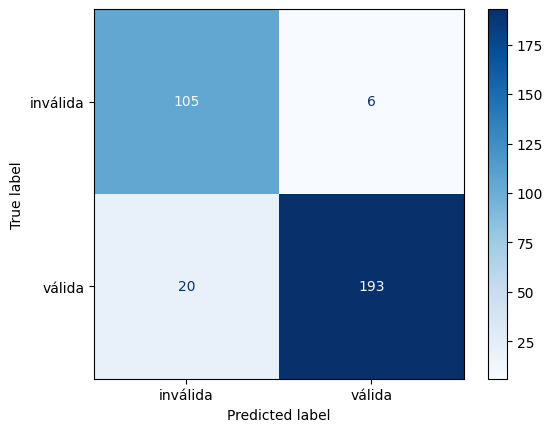

In [24]:
#Obtain predictions
predictions = originalDataTrainer.predict(originalDataDict["test"])

#Extract logits and calculate final predictions
logits = predictions.predictions
yPred = np.argmax(logits, axis = 1)
yTrue = predictions.label_ids

#Print the clasification metrics
print("Classification Report:\n")
print(classification_report(yTrue, yPred, target_names = ['inválida', 'válida']))

#Confusion matrix
cm = confusion_matrix(yTrue, yPred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['inválida', 'válida'])
disp.plot(cmap = "Blues")